# Final Model
![model.png](attachment:ee14989c-1b12-4001-b149-236cfbdf7afb.png)
**NOTE**: Shape dimensions are (batch_size, tensor_size).

In [ ]:
# Model final parameters
pprint.pprint(PARAMETERS)

{'BATCH_SIZE': 64,
 'EARLY_STOPPING': {'delta_rating': 0.01,
                    'delta_retrieval': 0.01,
                    'patience': 3,
                    'rating_metric': 'val_root_mean_squared_error',
                    'retrieval_metric': 'val_factorized_top_k/top_50_categorical_accuracy',
                    'start_from_epoch': 5},
 'FEATURES': {'PRODUCT': ['cat-product_id',
                          'cat-category_name',
                          'cat-merchant_name',
                          'cat-merchant_state',
                          'cat-merchant_region',
                          'int-free_shipping',
                          'int-is_sold_out',
                          'int-editor_pick',
                          'int-on_sale',
                          'text-product_name',
                          'disc-sales_last_week',
                          'disc-sales_last_month',
                          'disc-sales_last_year',
                          'disc-price_in_cen

## Cross Validation Evaluation
I will evaluate my model using cross-validation.

In [ ]:
params = copy.deepcopy(PARAMETERS)
params['LOGDIR'] = os.path.join(LOGPATH, 'selected_model')

results_df = train_CV(params)

Cross Validation: 100%|██████████| 5/5 [05:33<00:00, 66.67s/fold]


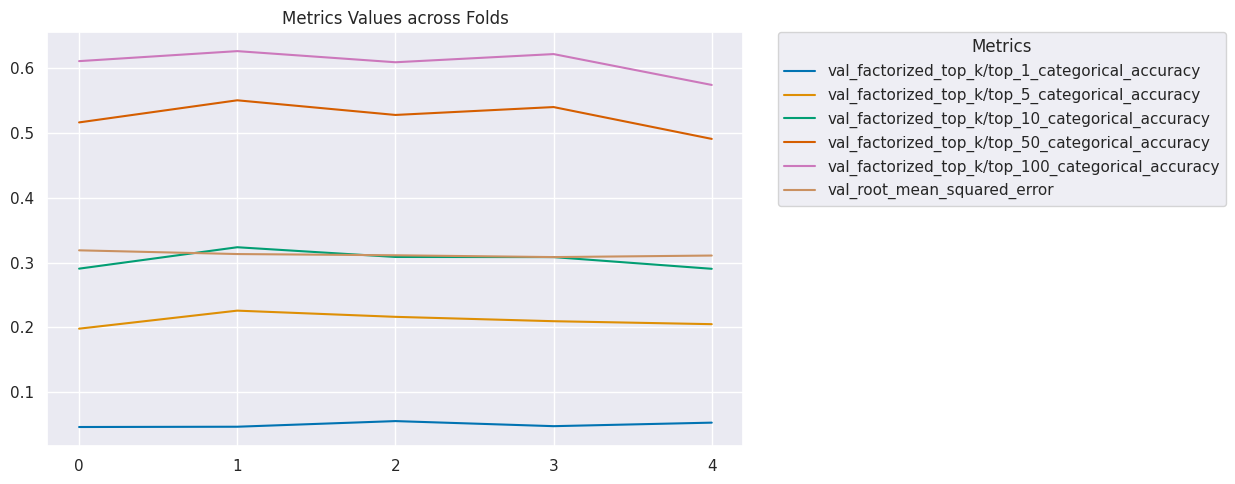

In [ ]:
cv_data = results_df.drop(['n_epochs', 'val_loss', 'val_regularization_loss', 'val_total_loss', 'fold'], axis=1)
fig = plt.figure(figsize=(15, 5))

for col in cv_data.columns:
    plt.plot(cv_data[col], label=col)

plt.xticks(range(0, 5))
plt.title('Metrics Values across Folds')
# Move the legend outside the plot area
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title='Metrics')

# Use tight layout to automatically adjust subplot params
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Leave space on the right for the legend
plt.show()

In [ ]:
# Metrics average
cv_data.mean()

val_factorized_top_k/top_1_categorical_accuracy      0.050174
val_factorized_top_k/top_5_categorical_accuracy      0.211024
val_factorized_top_k/top_10_categorical_accuracy     0.304297
val_factorized_top_k/top_50_categorical_accuracy     0.524609
val_factorized_top_k/top_100_categorical_accuracy    0.607812
val_root_mean_squared_error                          0.312454
dtype: float64

The obtained metric for `val_factorized_top_k/top_50_categorical_accuracy` is **0.52** and for `val_root_mean_squared_error` is **0.31**.
This tell us that, on average, the true positive is in the top 50 retrieved items 52% of the time. The ranking metric idea is to improve the position of the true positive in the retrieved list.

# Prediction

Make a prediction in order to initialize the model and build the imput tensor shape.

**Model Usage:**  
This process retrieves and ranks product recommendations based on user queries.  

1. **Retrieve Top Recommendations:**  
   Using the retrieval index, extract the top 1,000 recommendations for the given user query. These represent the products that the user is most likely to click on.  

2. **Predict Scores:**  
   For each pair of user query and recommended product, predict a relevance score using historical user feedback data. This score reflects the likelihood of the product being purchased.  

3. **Rank by Purchase Probability:**  
   Sort the recommendations based on the predicted scores in descending order. Items with scores closer to 1 are deemed highly purchaseable, while those closer to 0 are less likely to be purchased.

In [ ]:
def get_rank(item):
    # Discard unused features by the model
    input_data = {k: v for k, v in item.items() if k not in features_to_drop}
    _, _, score = final_model(input_data)
    item['score'] = score
    return item

def decode_values(item):
    for key, value in item.items():
        if isinstance(value, bytes):
            item[key] = value.decode('utf-8')
        if key == 'score':
            item[key] = value[0]
    return item

query_input = {
    'user_id': tf.convert_to_tensor(b'b7485193f4e7f5b8ac3c94f71f4456a9', dtype=tf.string),
    'channel': tf.convert_to_tensor(b'Organic', dtype=tf.string),
    'device_type': tf.convert_to_tensor(b'Desktop', dtype=tf.string),
    'query_text': tf.convert_to_tensor(b'pizza', dtype=tf.string),
    'time': tf.convert_to_tensor(b'2023-10-25 00:00:19.230', dtype=tf.string),
}

# Pass a user in, get top predicted products back.
_, recs= index({k: tf.expand_dims(v, axis=0) for k, v in query_input.items()})

# Filter by product id
rec_prods = products.filter(
    lambda item: tf.reduce_any(tf.equal(item['product_id'], recs[0]))
)

# Add query input
rec_prods_with_query = rec_prods.map(lambda x: {**query_input, **x})

# Get score
rec_prods_rank = rec_prods_with_query.batch(8).map(get_rank).unbatch()

# Order by score
recs_prods_sorted = sorted(
    list(rec_prods_rank.as_numpy_iterator()), 
    key=lambda x: x['score'], 
    reverse=True
)

# Decode values and return
recs_prods_last = list(map(decode_values, recs_prods_sorted))

recs_prods_last_df = pd.DataFrame(recs_prods_last)
recs_prods_last_df

,user_id,channel,device_type,query_text,time,product_id,category_name,merchant_name,merchant_city,merchant_state,merchant_region,free_shipping,is_sold_out,editor_pick,on_sale,product_name,sales_last_week,sales_last_month,sales_last_year,price_in_cents,reviews,score
0,b7485193f4e7f5b8ac3c94f71f4456a9,Organic,Desktop,pizza,2023-10-25 00:00:19.230,757017d543f4967856d6b34c42a340e3,Key Lime Pies,Kermit's Key West Key Lime Shoppe,Key West,FL Florida,south,1,0,1,0,Key Lime Pie,12,19,74,8495,60,0.253093
1,b7485193f4e7f5b8ac3c94f71f4456a9,Organic,Desktop,pizza,2023-10-25 00:00:19.230,12f51a952f2f2b8d46a0ce082f5eac24,Chicago Deep Dish Pizza,Lou Malnati's Pizza,Chicago,IL Illinois,midwest,1,0,0,0,2 Lou Malnati's Deep Dish Pizzas,15,27,123,8399,85,0.245077
2,b7485193f4e7f5b8ac3c94f71f4456a9,Organic,Desktop,pizza,2023-10-25 00:00:19.230,69cff3770cd5f7ac70a6b10f20951e83,,Utopia Bagels,Queens,NY New York,northeast,1,0,1,0,Bagels - Bakers Dozen,21,31,112,5995,71,0.235450
3,b7485193f4e7f5b8ac3c94f71f4456a9,Organic,Desktop,pizza,2023-10-25 00:00:19.230,205673a98f001e91276ae659b0aab433,Key Lime Pies,Key West Key Lime Pie Co.,Key West,FL Florida,south,1,0,0,0,Famous Key West Key Lime Pie,14,19,45,6995,24,0.232289
4,b7485193f4e7f5b8ac3c94f71f4456a9,Organic,Desktop,pizza,2023-10-25 00:00:19.230,a4f06155fe3016380e1f2c0a7af9470e,Brownies,Brownie Points,Columbus,OH Ohio,midwest,1,0,0,0,Halloween ''''Spooky Eyes'''' Brownie Bruffles,22,33,34,5995,66,0.229522
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,b7485193f4e7f5b8ac3c94f71f4456a9,Organic,Desktop,pizza,2023-10-25 00:00:19.230,ced42f1fac601e96f10bee45674a4207,Colorado-Style Pizza,Panhandler's Pizza,Fort Collins,CO Colorado,west,1,0,0,0,Deluxe Combo Colorado Pizza - 3 Pack,3,5,9,9995,21,-0.040529
996,b7485193f4e7f5b8ac3c94f71f4456a9,Organic,Desktop,pizza,2023-10-25 00:00:19.230,ef7fe02c7767a7b494738da4c1a28eb3,Colorado-Style Pizza,Panhandler's Pizza,Fort Collins,CO Colorado,west,1,0,0,0,Pepperoni Colorado Pizza - 3 Pack,2,4,7,9995,21,-0.040724
997,b7485193f4e7f5b8ac3c94f71f4456a9,Organic,Desktop,pizza,2023-10-25 00:00:19.230,f50d976e5740ac32cb7018e09254a93d,Meal Kits,Chef Tim Love,Fort Worth,TX Texas,southwest,1,0,0,0,Chicken Burrito Kit - 6 Pack,2,4,10,10495,24,-0.042369
998,b7485193f4e7f5b8ac3c94f71f4456a9,Organic,Desktop,pizza,2023-10-25 00:00:19.230,bc9e7e0bddbb22d326149c59569e200c,Pizza,Regina Pizzeria,Boston,MA Massachusetts,northeast,1,0,0,0,Sausage Pizza - 4 Pack,1,3,4,12495,46,-0.048521
